## Prepare the data



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
import cv2

In [3]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 128

# Size of the noise vector
noise_dim = 128


X_data = []
Y_data = []

path = "/content/drive/MyDrive/NNDL/HW6/Dataset/Class "
for i in range(5):
  files = glob.glob(path + str(i+1) + "/*.png")
  for myFile in files:
    image = cv2.imread(myFile,0)
    res = cv2.resize(image, dsize=(28, 28))
    # image = cv2.IMREAD_GRAYSCALE (myFile)
    X_data.append (res)
    Y_data.append (i+1)

X_data = np.array(X_data)
Y_data = np.array(Y_data)
print('X_data shape:', X_data.shape)
print('Y_data shape:', Y_data.shape)

X_data shape: (1005, 28, 28)
Y_data shape: (1005,)


In [4]:
train_images = np.array(X_data).reshape(1005, *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5
print('train_images shape:', train_images.shape)


train_images shape: (1005, 28, 28, 1)


In [5]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 32, 32, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                     

## generator

In [6]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              524288    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                       

## WGAN-GP 

In [8]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):

        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


callback for saving generated images

In [10]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=20, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        if epoch % 20 == 0:
          for i in range(self.num_img):
              img = generated_images[i].numpy()
              img = keras.preprocessing.image.array_to_img(img)
              img.save("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


## Train

In [11]:
# (learning_rate=0.0002, beta_1=0.5)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)


def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


epochs = 101

cbk = GANMonitor(num_img=20, latent_dim=noise_dim)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

In [12]:
results = wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/101
8/8 [==============================] - 17s 461ms/step - d_loss: -10.0120 - g_loss: -7.8164
Epoch 2/101
8/8 [==============================] - 2s 301ms/step - d_loss: -13.4086 - g_loss: -15.4459
Epoch 3/101
8/8 [==============================] - 2s 302ms/step - d_loss: -12.4062 - g_loss: -15.9607
Epoch 4/101
8/8 [==============================] - 2s 303ms/step - d_loss: -11.6103 - g_loss: -15.9054
Epoch 5/101
8/8 [==============================] - 2s 304ms/step - d_loss: -11.1416 - g_loss: -16.3978
Epoch 6/101
8/8 [==============================] - 2s 304ms/step - d_loss: -10.7635 - g_loss: -17.8916
Epoch 7/101
8/8 [==============================] - 2s 305ms/step - d_loss: -10.5796 - g_loss: -18.4804
Epoch 8/101
8/8 [==============================] - 2s 306ms/step - d_loss: -10.3069 - g_loss: -17.8982
Epoch 9/101
8/8 [==============================] - 2s 308ms/step - d_loss: -10.2869 - g_loss: -18.5015
Epoch 10/101
8/8 [==============================] - 2s 308ms/step - d_los

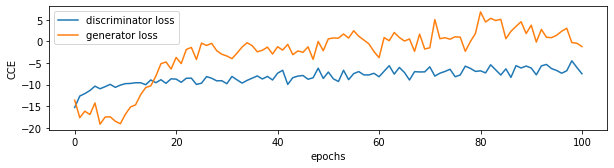

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 

d_loss = results.history['d_loss']
g_loss = results.history['g_loss']


plt.subplots(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(d_loss)
plt.plot(g_loss)

plt.legend(['discriminator loss', 'generator loss'])
plt.xlabel('epochs')
plt.ylabel('CCE')


plt.show()

Display the last generated images:

In [15]:
from IPython.display import Image, display

display(Image("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_0_100.png"))
display(Image("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_1_100.png"))
display(Image("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_2_100.png"))
display(Image("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_3_100.png"))
display(Image("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_4_100.png"))
display(Image("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_5_100.png"))
display(Image("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_6_100.png"))
display(Image("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_7_100.png"))
display(Image("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_8_100.png"))
display(Image("/content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_9_100.png"))

In [16]:
!zip -r /content/drive/MyDrive/NNDL/HW6//WGAN-GP-out.zip /content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images

  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/ (stored 0%)
  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_0_0.png (stored 0%)
  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_1_0.png (stored 0%)
  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_2_0.png (stored 0%)
  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_3_0.png (stored 0%)
  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_4_0.png (stored 0%)
  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_5_0.png (stored 0%)
  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_6_0.png (stored 0%)
  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_7_0.png (stored 0%)
  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_img_8_0.png (stored 0%)
  adding: content/drive/MyDrive/NNDL/HW6/WGAN/WGAN-GP-Images/generated_